Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  9.12227417169e+13
Right lane curve radius:  1.41130478738e+15


/Users/jessica/GitHub/self-driving-car-nd/p4-advanced-lane-lines/helperfunctions.py:281: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(warped_thresholded_image[window_end_y:window_start_y, :], axis=0)
/Users/jessica/GitHub/self-driving-car-nd/p4-advanced-lane-lines/helperfunctions.py:222: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]


array([[[187, 148,  92],
        [186, 148,  90],
        [186, 147,  91],
        ..., 
        [178, 131,  73],
        [178, 131,  73],
        [178, 131,  73]],

       [[187, 147,  93],
        [186, 147,  92],
        [186, 147,  92],
        ..., 
        [177, 130,  72],
        [177, 130,  72],
        [177, 130,  72]],

       [[187, 147,  95],
        [186, 146,  93],
        [186, 146,  93],
        ..., 
        [178, 130,  73],
        [178, 130,  74],
        [178, 130,  74]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [ 86,  87, 107],
        [ 86,  87, 107],
        [ 86,  87, 107]],

       [[219, 207, 225],
        [255, 248, 255],
        [255, 255, 255],
        ..., 
        [ 86,  87, 107],
        [ 86,  87, 107],
        [ 86,  87, 107]],

       [[157, 147, 163],
        [206, 196, 212],
        [255, 246, 255],
        ..., 
        [ 83,  86, 106],
        [ 84,  86, 106],
        [ 84,  86,

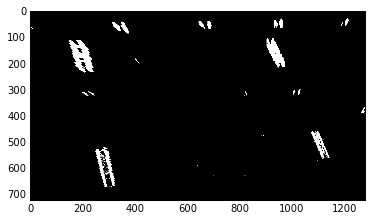

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def image_pipeline(filepath):
    # Read in image
    raw = cv2.imread(filepath)

    # Parameters
    imshape = raw.shape

    src = np.float32(
        [[0, 720],
         [550, 470],
         [700, 470],
         [720, 1280]])

    dst = np.float32(
        [[200, 720],
         [200, 0],
         [900, 0],
         [900, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    combined_binary = apply_threshold_v2(image)

    # Plotting thresholded images
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Option 1')
    ax1.imshow(combined, cmap="gray")

    ax2.set_title('Option 2: Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    """

    # Warp onto birds-eye-view
    # Previous region-of-interest mask's function is absorbed by the warp
    warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    plt.imshow(warped, cmap="gray")


    # Histogram and get pixels in window

    leftx, lefty, rightx, righty = histogram_pixels(warped)

    left_fit = fit_second_order_poly(lefty, leftx)
    right_fit = fit_second_order_poly(righty, rightx)

    # Plot data
    #    plt.plot(left_fitx, lefty, color='green', linewidth=3)
    #    plt.plot(right_fitx, righty, color='green', linewidth=3)
    #    plt.imshow(warped, cmap="gray")

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) \
                    / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) \
                     / np.absolute(2 * right_fit[0])
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)

    # TODO: Det vehicle position wrt centre

    ## 7. Warp the detected lane boundaries back onto the original image.

    polyfit_left = draw_poly(blank_canvas, lane_poly, left_fit, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_fit, 30)
    # plt.imshow(polyfit_drawn, cmap="gray")

    lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(lane_lines, cmap="gray")


    # Convert to colour
    lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    combined_img = cv2.add(lane_line_colour, image)
#    plt.imshow(combined_img)
    return combined_img

image_pipeline("test_images/quiz.png")
# plt.imshow()